<a href="https://colab.research.google.com/github/venkateshtantravahi/CNN-Architectures/blob/main/ResNet50_Tensorflow2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Required imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

In [2]:
#Load CIFAR10 Dataset
(train_im,train_lab),(test_im,test_lab) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
#Normalize the data 
train_im, test_im = train_im/255.0, test_im/255.0
#check the format of the data
print("train_im, train_lab types:", type(train_im), type(train_lab))
#Check the shape of data
print("shape of images and labels array:", train_im.shape, train_lab.shape)
print("shape of images and labels array; test:",test_im.shape, test_lab.shape)

train_im, train_lab types: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape of images and labels array: (50000, 32, 32, 3) (50000, 1)
shape of images and labels array; test: (10000, 32, 32, 3) (10000, 1)


In [4]:
#Unique elements in dataset
(unique, count) = np.unique(train_lab, return_counts=True)

frequency = np.asarray((unique, count)).T

print(frequency)
print(len(unique))

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]
10


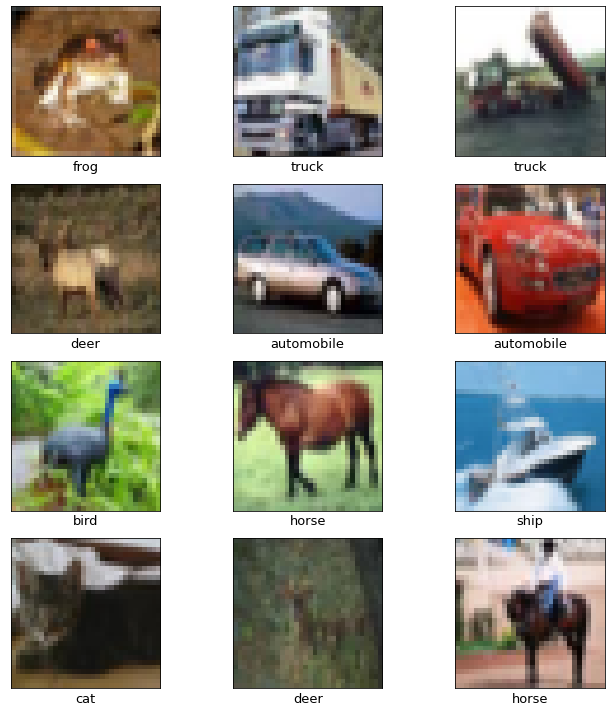

In [5]:
#From cifar-10 main site
class_types = ['airplane','automobile','bird','cat',
              'deer','dog','frog','horse','ship','truck']

plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_im[i], cmap='gray')
    plt.xlabel(class_types[train_lab[i][0]], fontsize=13)
plt.tight_layout()
plt.show()

In [6]:
#encodings for labels
train_lab_categorical = tf.keras.utils.to_categorical(train_lab, num_classes=10,dtype='uint8')
test_lab_categorical = tf.keras.utils.to_categorical(test_lab, num_classes=10,dtype='uint8')

In [7]:
print(len(train_lab_categorical))

50000


In [8]:
print(len(test_lab_categorical))

10000


In [9]:
#train-test split

from sklearn.model_selection import train_test_split
train_im, valid_im, train_lab, valid_lab = train_test_split(train_im, 
                                                           train_lab_categorical,test_size=0.20,stratify=train_lab_categorical,random_state=40,shuffle=True)
print("train data shape after the split:", train_im.shape)
print("new validation data shape:", valid_im.shape)
print("validation labels shape:",valid_lab.shape)

"""
Params used in train_test_split of sklearn
sklearn.model_selection.train_test_split(*arrays, test_size=None, 
train_size=None, random_state=None, shuffle=True, stratify=None)

Definition: Spilts dataset into random train and validation sets.

Parameters:
*arrays: Sequence of indexables with same length or shape[0]

    Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
test_sizefloat or int, default=None

test_size:float or int,default:None
    If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. If train_size is also None, it will be set to 0.25.
train_sizefloat or int, default=None

train_size:float or int, default:None
    If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. If int, represents the absolute number of train samples. If None, the value is automatically set to the complement of the test size.
random_stateint, RandomState instance or None, default=None

random_state:int,RandomState_instance or None, default:None
    Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls. See Glossary.
shufflebool, default=True

shuffle:bool,default:True
    Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.
stratifyarray-like, default=None

Stratify:array-like, default:none
    If not None, data is split in a stratified fashion, using this as the class labels
"""

train data shape after the split: (40000, 32, 32, 3)
new validation data shape: (10000, 32, 32, 3)
validation labels shape: (10000, 10)


'\nParams used in train_test_split of sklearn\nsklearn.model_selection.train_test_split(*arrays, test_size=None, \ntrain_size=None, random_state=None, shuffle=True, stratify=None)\n\nDefinition: Spilts dataset into random train and validation sets.\n\nParameters:\n*arrays: Sequence of indexables with same length or shape[0]\n\n    Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.\ntest_sizefloat or int, default=None\n\ntest_size:float or int,default:None\n    If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. If train_size is also None, it will be set to 0.25.\ntrain_sizefloat or int, default=None\n\ntrain_size:float or int, default:None\n    If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. If int, represents

In [10]:
#Neccessary imports for building neural-net

from keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add
from keras.models import Model
from keras import activations
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [11]:
#Data Agmentation
batch_size = 64

train_data_generation = keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2,
                                                                    width_shift_range=0.1,
                                                                    height_shift_range=0.1,
                                                                    horizontal_flip=True)
valid_data_generated = keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_data_generation.flow(train_im, train_lab, batch_size=batch_size)
valid_set_conv = valid_data_generated.flow(valid_im, valid_lab, batch_size=batch_size)

In [12]:
def res_identity(x, filters): 
  ''' renet block where dimension doesnot change.
  The skip connection is just simple identity conncection
  we will have 3 blocks and then input will be added
  '''
  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [13]:
def res_conv(x, s, filters):
  '''
  here the input size changes, when it goes via conv blocks
  so the skip connection uses a projection (conv layer) matrix
  ''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [14]:
### Combine the above functions to build 50 layers resnet. 
def resnet50():

  input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model


In [15]:
#callbacks
def learningRateDecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 80:
        lr *= 1e-1
        
    return lr

learningRateDecay = keras.callbacks.LearningRateScheduler(learningRateDecay)

def earlyStop(mode):
    if mode == 'acc':
        estop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
    elif mode == 'loss':
        estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
        
    return estop

In [16]:
resnet50_model = resnet50()

In [17]:
print(resnet50_model.summary())

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
___________________________________________________________________________________________

In [18]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=1e-3),metrics=['acc'])

In [19]:
batch_size=batch_size

resnet_train = resnet50_model.fit(train_set_conv,
                                 epochs=160,
                                 steps_per_epoch=train_im.shape[0]/batch_size,
                                 validation_steps=valid_im.shape[0]/batch_size,
                                 validation_data=valid_set_conv,
                                 callbacks=[learningRateDecay])

Epoch 1/160
625/625 [==============================] - 49s 57ms/step - loss: 17.5810 - acc: 0.2761 - val_loss: 56.7034 - val_acc: 0.1839
Epoch 2/160
625/625 [==============================] - 34s 55ms/step - loss: 9.2517 - acc: 0.3388 - val_loss: 6.8434 - val_acc: 0.2921
Epoch 3/160
625/625 [==============================] - 34s 55ms/step - loss: 5.9215 - acc: 0.3960 - val_loss: 4.9023 - val_acc: 0.3037
Epoch 4/160
625/625 [==============================] - 34s 55ms/step - loss: 4.7985 - acc: 0.3813 - val_loss: 4.2229 - val_acc: 0.2552
Epoch 5/160
625/625 [==============================] - 34s 54ms/step - loss: 3.9682 - acc: 0.3956 - val_loss: 4.1940 - val_acc: 0.2001
Epoch 6/160
625/625 [==============================] - 34s 54ms/step - loss: 3.8589 - acc: 0.3495 - val_loss: 6.4990 - val_acc: 0.1018
Epoch 7/160
625/625 [==============================] - 34s 54ms/step - loss: 3.5579 - acc: 0.3965 - val_loss: 19675.9434 - val_acc: 0.1000
Epoch 8/160
625/625 [============================

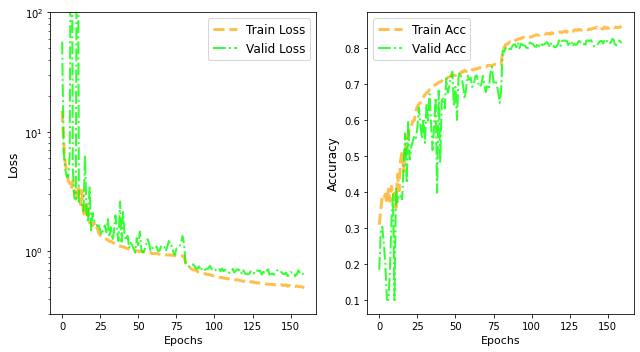

In [20]:
### Plot train and validation curves
loss = resnet_train.history['loss']
v_loss = resnet_train.history['val_loss']

acc = resnet_train.history['acc']
v_acc = resnet_train.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [23]:
#### Plot the Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(test_lab, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(test_lab,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()

Classification Report:

              precision    recall  f1-score   support

    airplane       0.49      0.91      0.64      1000
  automobile       0.90      0.90      0.90      1000
        bird       0.81      0.73      0.77      1000
         cat       0.80      0.49      0.60      1000
        deer       0.84      0.76      0.80      1000
         dog       0.87      0.57      0.69      1000
        frog       0.74      0.92      0.82      1000
       horse       0.91      0.83      0.87      1000
        ship       0.90      0.90      0.90      1000
       truck       0.90      0.86      0.88      1000

    accuracy                           0.79     10000
   macro avg       0.82      0.79      0.79     10000
weighted avg       0.82      0.79      0.79     10000



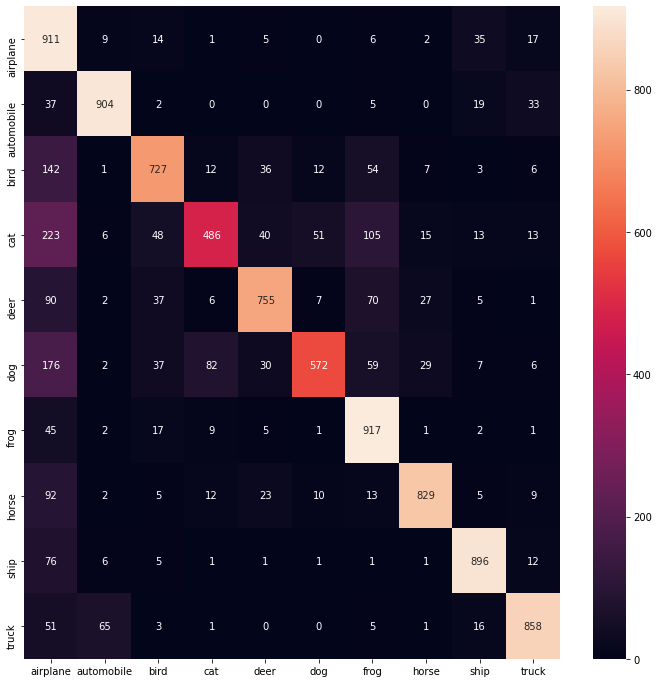

In [22]:
pred_class_resnet50 = resnet50_model.predict(test_im)

conf_matrix(pred_class_resnet50)